# Assignment 2
## 1. Properties of CNNs
### Question 1.2 (a)

In this first part, we will train a CNN model over the dataset CIFAR-10. This dataset contains 10 classes: plane, car, bird, cat, deer, dog, frog, horse, ship and truck.

First, let's load the data:

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# Import data from CIFAR-10
# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),])

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Create a function to display the first 25 images of a dataset with their corresponding class name and use it over `train_data`.

Hint: `class_names = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]`, where the labels are the corresponding index.
   

In [3]:
def display_first_few_images(data):
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    class_names = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    labels_map = {i: class_names[i] for i in range(len(class_names))}
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        npimg = img.numpy()   # convert from tensor
        plt.imshow(np.transpose(npimg, (1, 2, 0)))  # convert from (C, H, W) to (H, W, C)
    plt.show()
    #######################
    # END OF YOUR CODE    #
    #######################

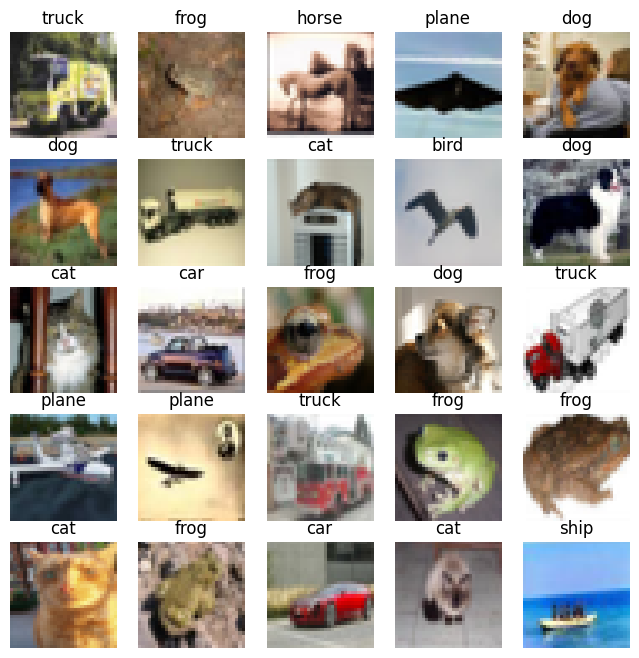

In [4]:
display_first_few_images(train_data)

Now, we will load and train a small CNN model! In the following cells you can check the architecture of the model and the designed function for its training.

Note: You shouldn't need Snellius to run it. Either Google Collab or your local computer should be enough.

In [5]:
# Define the model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function for training the model
def train(model, train_loader, epochs = 10):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

In [6]:
# Initialize the model
model = CNN().to(device)

# Train the model
train(model, train_loader)

100%|██████████| 782/782 [00:22<00:00, 35.37it/s]


Epoch 1, Loss: 1.6210


100%|██████████| 782/782 [00:14<00:00, 54.32it/s]


Epoch 2, Loss: 1.2694


100%|██████████| 782/782 [00:11<00:00, 65.85it/s]


Epoch 3, Loss: 1.1085


100%|██████████| 782/782 [00:10<00:00, 72.85it/s]


Epoch 4, Loss: 0.9857


100%|██████████| 782/782 [00:10<00:00, 72.96it/s]


Epoch 5, Loss: 0.8966


100%|██████████| 782/782 [00:10<00:00, 73.15it/s]


Epoch 6, Loss: 0.8232


100%|██████████| 782/782 [00:14<00:00, 53.82it/s]


Epoch 7, Loss: 0.7629


100%|██████████| 782/782 [00:10<00:00, 73.12it/s]


Epoch 8, Loss: 0.7165


100%|██████████| 782/782 [00:10<00:00, 72.55it/s]


Epoch 9, Loss: 0.6801


100%|██████████| 782/782 [00:10<00:00, 72.39it/s]

Epoch 10, Loss: 0.6407


Now, we want to check the performance of the trained model for the test dataset when rotating the images 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330 and 360 degrees.

For this, you need to first create the function `get_acc_per_angle` that computes the accuracies_per_angle for a given model. You should create a `rotated_test_data` and a `rotated_test_loader`, from which taking the images and labels to give as input to the `inference` function that is provided to you in the following cell.

Then, create a `plot` function that plots the accuracy of the model per angle of rotation of the images.   

Hint: Check how we used transformations in section a.

In [7]:
def inference(model, images, labels):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    return predictions

In [8]:
def get_acc_per_angle(model):
    angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
    angle_accuracies = []

    with torch.no_grad():
        for angle in angles:
            #######################
            # PUT YOUR CODE HERE  #
            #######################
            transform = transforms.Compose([
                transforms.Lambda(lambda img: transforms.functional.rotate(img, angle)),
                transforms.ToTensor()
            ])

            rotated_test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
            rotated_test_loader = torch.utils.data.DataLoader(rotated_test_data, batch_size=64, shuffle=False)

            total_correct = 0
            total_samples = 0

            for images, labels in rotated_test_loader:
                preds = inference(model, images, labels)

                total_correct += (preds == labels.to(device)).sum().item()
                total_samples += labels.size(0)

            acc = (total_correct / total_samples) * 100
            angle_accuracies.append(acc)

            #######################
            # END OF YOUR CODE    #
            #######################

    return angles, angle_accuracies

In [26]:
angles, angle_accuracies = get_acc_per_angle(model)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [12]:
# Plot accuracy vs rotation angle
def plot(angles, angle_accuracies):
            #######################
            # PUT YOUR CODE HERE  #
            #######################
    plt.figure(figsize=(10, 6))
    plt.plot(angles, angle_accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
    plt.title('Accuracy vs Rotation Angle')
    plt.xlabel('Rotation Angle (degrees)')
    plt.ylabel('Accuracy (%)')
    plt.xticks(angles)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

            #######################
            # END OF YOUR CODE    #
            #######################

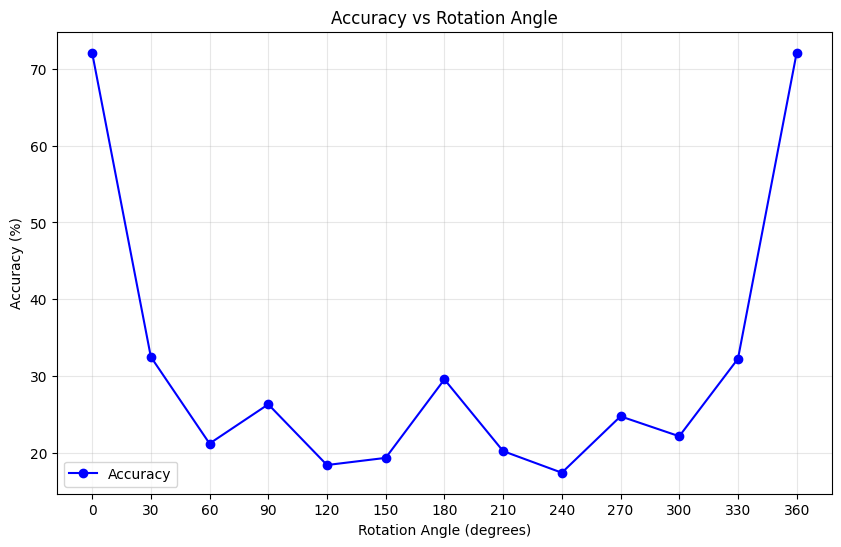

In [28]:
plot(angles,angle_accuracies)

### Question 1.2 (b)

As said in the pdf, now we will first train a model with the same architecture as the previous one (this is, you can use the same to initialize the model as before), changing the train dataset so that it contains _random rotations_ of angles of up to 360 degrees. For this, create a new `train_augmentation_transform` to create the train augmented dataset.

Hint: Check how we used transformations in Question 1.2 (a)

Files already downloaded and verified


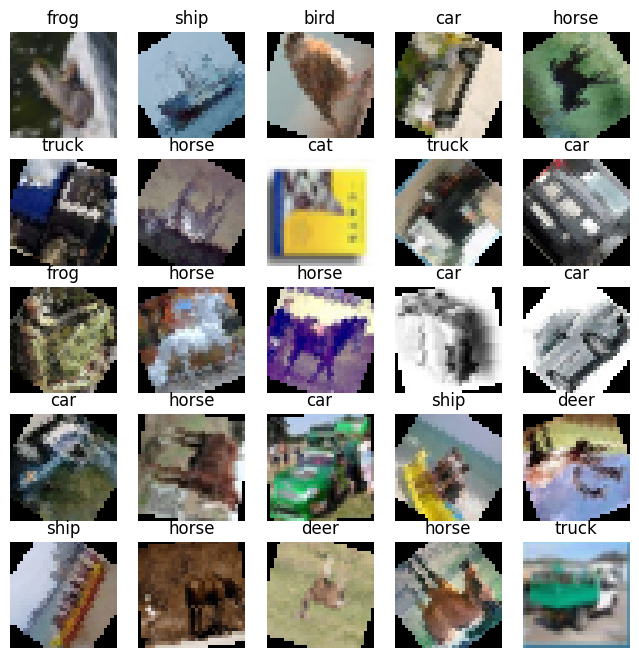

In [9]:
# Create the new train data and loader and visualize it

#######################
# PUT YOUR CODE HERE  #
#######################
train_augmentation_transform = transforms.Compose([
                transforms.RandomRotation(degrees=(0, 360)),
                transforms.ToTensor()
            ])
#######################
# END OF YOUR CODE    #
#######################

train_augmented_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_augmentation_transform)
train_augmented_loader = torch.utils.data.DataLoader(train_augmented_data, batch_size=64, shuffle=True)


display_first_few_images(train_augmented_data)

As said, we will now initialize the new model and train it over the `train_augmented_loader` you just created. Initialized the new model as we did in the previous question and train it using the `train` function.

Note: Again, you shouldn't need Snellius to run it

In [10]:
#######################
# PUT YOUR CODE HERE  #
#######################

# Initialize the model
model = CNN().to(device)

# Train the model with augmented loader
train(model, train_augmented_loader)

#######################
# END OF YOUR CODE    #
#######################

100%|██████████| 782/782 [00:15<00:00, 49.51it/s]


Epoch 1, Loss: 1.9547


100%|██████████| 782/782 [00:16<00:00, 47.67it/s]


Epoch 2, Loss: 1.7093


100%|██████████| 782/782 [00:16<00:00, 48.02it/s]


Epoch 3, Loss: 1.6005


100%|██████████| 782/782 [00:16<00:00, 47.19it/s]


Epoch 4, Loss: 1.5401


100%|██████████| 782/782 [00:16<00:00, 47.93it/s]


Epoch 5, Loss: 1.4908


100%|██████████| 782/782 [00:15<00:00, 49.79it/s]


Epoch 6, Loss: 1.4504


100%|██████████| 782/782 [00:15<00:00, 49.78it/s]


Epoch 7, Loss: 1.4253


100%|██████████| 782/782 [00:16<00:00, 47.06it/s]


Epoch 8, Loss: 1.3957


100%|██████████| 782/782 [00:16<00:00, 46.80it/s]


Epoch 9, Loss: 1.3705


100%|██████████| 782/782 [00:15<00:00, 49.51it/s]

Epoch 10, Loss: 1.3579


Now, evaluate its performance by running inference over the dataset when rotating the images 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330 and 360 degrees, and plotting the model's accuracy respect to the angle of rotation of the test dataset. You can use `get_acc_per_angle` and `plot` functions you defined in Question 1.2 (a)!

Hint: The test data is the same as in Question 1.2 (a)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


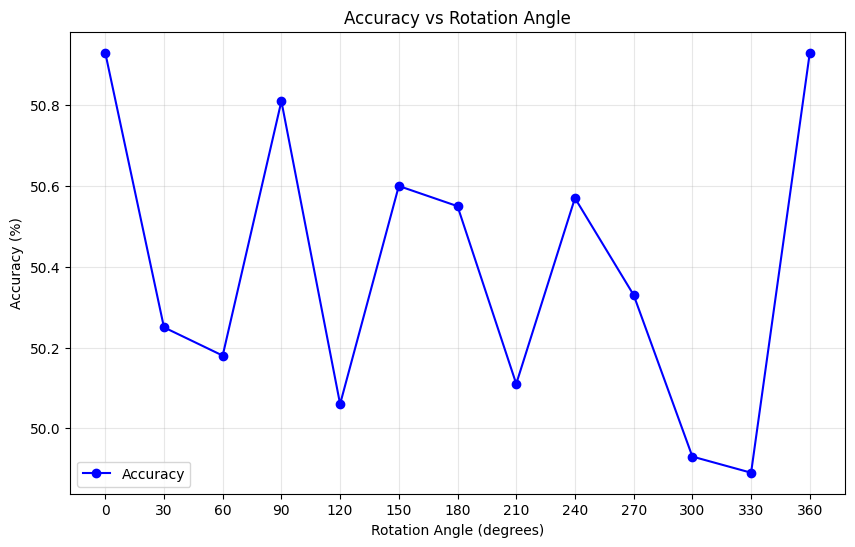

In [13]:
#######################
# PUT YOUR CODE HERE  #
#######################

angles, angle_accuracies = get_acc_per_angle(model)
plot(angles,angle_accuracies)

#######################
# END OF YOUR CODE    #
#######################